In [1]:
import os
import re
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from bpemb import BPEmb
from sklearn import svm
from sklearn import metrics
from pathlib import PosixPath
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore")

# DARSHAN

# Nikhil

In [2]:
bpemb = BPEmb(lang="id", cache_dir=PosixPath('../runs/downloaded_models/'))

In [3]:
DATA_DIR = "../data/interim/2022-01-06_combined_orc_kyc"
DATA_KEY_DIR = "../data/interim/2022-01-06_combined_orc_kyc-key-fields"
TRAIN_DATA_KTP_KEY_FIELD_DIR = f"{DATA_KEY_DIR}/KTP_TRAIN"
VAL_DATA_KTP_KEY_FIELD_DIR = f"{DATA_KEY_DIR}/KTP_VAL"
TEST_DATA_KTP_KEY_FIELD_DIR = f"{DATA_KEY_DIR}/KTP_TEST"
ANNOTATION_FILE = f"{DATA_DIR}/ktp_ground_truth.csv"
KTP_KEY_FIELD_CLASS_FILE = f"{TRAIN_DATA_KTP_KEY_FIELD_DIR}/classes.txt"
RESIZE = (480, 256)

In [4]:
with open(KTP_KEY_FIELD_CLASS_FILE) as f:
    lines = f.readlines()
classes = [item.strip() for item in lines]
ind_to_classes_mapping = {str(i): val for i, val in enumerate(classes)}
classes_to_ind_mapping = {val: key for key, val in ind_to_classes_mapping.items()}
print(f'Classes -> {classes}\nTotal number of classes = {len(classes)}')
print(f'Index to class mapping ->\n{ind_to_classes_mapping}')
print(f'Class to index mapping ->\n{classes_to_ind_mapping}')

Classes -> ['TEXT', 'NIK', 'NAMA', 'TEXTUNUSED', 'JENIS_KELAMIN', 'TEMPAT/TGL_LAHIR', 'ALAMAT', 'RT_RW', 'KEL_DESA', 'KECAMATAN', 'AGAMA', 'STATUS_PERKAWINAN', 'PEKERJAAN', 'KEWARGANEGARAAN', 'BERLAKU_HINGGA']
Total number of classes = 15
Index to class mapping ->
{'0': 'TEXT', '1': 'NIK', '2': 'NAMA', '3': 'TEXTUNUSED', '4': 'JENIS_KELAMIN', '5': 'TEMPAT/TGL_LAHIR', '6': 'ALAMAT', '7': 'RT_RW', '8': 'KEL_DESA', '9': 'KECAMATAN', '10': 'AGAMA', '11': 'STATUS_PERKAWINAN', '12': 'PEKERJAAN', '13': 'KEWARGANEGARAAN', '14': 'BERLAKU_HINGGA'}
Class to index mapping ->
{'TEXT': '0', 'NIK': '1', 'NAMA': '2', 'TEXTUNUSED': '3', 'JENIS_KELAMIN': '4', 'TEMPAT/TGL_LAHIR': '5', 'ALAMAT': '6', 'RT_RW': '7', 'KEL_DESA': '8', 'KECAMATAN': '9', 'AGAMA': '10', 'STATUS_PERKAWINAN': '11', 'PEKERJAAN': '12', 'KEWARGANEGARAAN': '13', 'BERLAKU_HINGGA': '14'}


In [5]:
order_mapping = {
    'TEXT': 0,
    'TEXTUNUSED': 0,
    'NIK': 1,
    'NAMA': 2,
    'TEMPAT/TGL_LAHIR': 3,
    'JENIS_KELAMIN': 4,
    'ALAMAT': 5,
    'RT_RW': 6,
    'KEL_DESA': 7,
    'KECAMATAN': 8,
    'AGAMA': 9,
    'STATUS_PERKAWINAN': 10,
    'PEKERJAAN': 11,
    'KEWARGANEGARAAN': 12,
    'BERLAKU_HINGGA': 13
}
number_of_key_fields = 13

In [6]:
def clean_data(path):
    key_field_files = os.listdir(path)
    data_keys = []
    for ind, key_field_file in tqdm(enumerate(key_field_files)):
        try:
            if '.jpg' in key_field_file or '.jpeg' in key_field_file or '.png' in key_field_file or '.webp' in key_field_file:
                file_name = key_field_file.split('.')[0]
                with open(os.path.join(path, file_name+'.txt')) as f:
                    lines = f.readlines()
                yolo_bbox = [item.strip() for item in lines]
                with open(os.path.join(path, file_name+'.json')) as json_file:
                    data = json.load(json_file)
                image_width = data['fullTextAnnotation']['pages'][0]['width']
                image_height = data['fullTextAnnotation']['pages'][0]['height']
                x_diff, y_diff = 0, 0
                n_image_width, n_image_height = 0, 0
                for i in range(len(yolo_bbox)):
                    # Value without cropping
                    xmin = min(data['textAnnotations'][i]['boundingPoly']['vertices'][0]['x'], data['textAnnotations'][i]['boundingPoly']['vertices'][3]['x'])
                    xmax = max(data['textAnnotations'][i]['boundingPoly']['vertices'][1]['x'], data['textAnnotations'][i]['boundingPoly']['vertices'][2]['x'])
                    ymin = min(data['textAnnotations'][i]['boundingPoly']['vertices'][0]['y'], data['textAnnotations'][i]['boundingPoly']['vertices'][1]['y'])
                    ymax = max(data['textAnnotations'][i]['boundingPoly']['vertices'][2]['y'], data['textAnnotations'][i]['boundingPoly']['vertices'][3]['y'])
                    data['textAnnotations'][i]['cx'], data['textAnnotations'][i]['cy'] = (xmax + xmin) // 2, (ymax + ymin) // 2
                    # Value with cropping | google vision api
                    if i == 0:
                        x_diff, y_diff = xmin, ymin
                        n_image_width = xmax - xmin
                        n_image_height = ymax - ymin
                    top_left = (data['textAnnotations'][i]['boundingPoly']['vertices'][0]['x'] - x_diff, data['textAnnotations'][i]['boundingPoly']['vertices'][0]['y'] - y_diff)
                    top_right = (data['textAnnotations'][i]['boundingPoly']['vertices'][1]['x'] - x_diff, data['textAnnotations'][i]['boundingPoly']['vertices'][1]['y'] - y_diff)
                    bottom_right = (data['textAnnotations'][i]['boundingPoly']['vertices'][2]['x'] - x_diff, data['textAnnotations'][i]['boundingPoly']['vertices'][2]['y'] - y_diff)
                    bottom_left = (data['textAnnotations'][i]['boundingPoly']['vertices'][3]['x'] - x_diff, data['textAnnotations'][i]['boundingPoly']['vertices'][3]['y'] - y_diff)
                    data['textAnnotations'][i]['boundingPoly']['normalized_vertices'] = [
                        {'x': x, 'y': y} for x, y in [top_left, top_right, bottom_right, bottom_left]
                    ]
                    n_xmin = min(top_left[0], bottom_left[0])
                    n_xmax = max(top_right[0], bottom_right[0])
                    n_ymin = min(top_left[1], top_right[1])
                    n_ymax = max(bottom_right[1], bottom_left[1])
                    data['textAnnotations'][i]['n_cx'], data['textAnnotations'][i]['n_cy'] = (n_xmax + n_xmin) // 2, (n_ymax + n_ymin) // 2
                    data['textAnnotations'][i]['class_index'] = yolo_bbox[i].split()[0]
                    data['textAnnotations'][i]['class'] = ind_to_classes_mapping[yolo_bbox[i].split()[0]]
                    if yolo_bbox[i].split()[0] == '0':
                        data['textAnnotations'][i]['is_key'] = False
                    else:
                        data['textAnnotations'][i]['is_key'] = True
                data_keys.append(
                    {   
                        'file_name': file_name,
                        'file_path': os.path.join(path, key_field_file),
                        'image_width': image_width,
                        'image_height': image_height,
                        'normalized_image_width': n_image_width,
                        'normalized_image_height': n_image_height,
                        'data': data['textAnnotations']
                    }
                )
        except Exception as e:
            continue
    return data_keys

data_key_train = clean_data(TRAIN_DATA_KTP_KEY_FIELD_DIR)
data_key_val = clean_data(VAL_DATA_KTP_KEY_FIELD_DIR)
data_key_test = clean_data(TEST_DATA_KTP_KEY_FIELD_DIR)

284it [00:00, 558.87it/s]
39it [00:00, 399.32it/s]
75it [00:00, 405.32it/s]


In [7]:
print(f"Train length = {len(data_key_train)}\nVal Length = {len(data_key_val)}\nTest Length = {len(data_key_test)}")

Train length = 80
Val Length = 13
Test Length = 23


In [8]:
def resize_point(image_width, image_height, point, size=RESIZE):
    new_w, new_h = size
    ratio_w = new_w / image_width
    ratio_h = new_h / image_height
    return (point[0] * ratio_w, point[1] * ratio_h)

def get_df(raw_data):
    data_list = []
    for ind, data in tqdm(enumerate(raw_data)):
        for i, item in enumerate(data['data']):
            if i == 0:
                continue
            center_coords = resize_point(data['normalized_image_width'], data['normalized_image_height'], (item['n_cx'], item['n_cy']))
            base_data = [
                    data['file_name'],
                    item['description'],
                ]
            derived_data = [
                    center_coords[0]/RESIZE[0], 
                    center_coords[1]/RESIZE[1],
                    data['normalized_image_width'],
                    data['normalized_image_height']
            ]
            text_embeddings = list(np.mean(bpemb.embed(item['description']), axis=0))
            labels = [
                order_mapping[item['class']]/number_of_key_fields,
                int(item['is_key']),
                int(item['class_index'])
            ]
            data_list.append(
                base_data + derived_data + text_embeddings + labels
            )
    return pd.DataFrame(data_list, columns=
                        ['file_name', 'text']
                      + ['c_x', 'c_y', 'n_image_width', 'n_image_height']
                      + [str(i+1) for i in range(100)]
                      + ['order', 'is_key', 'key_label']
                    )

train_df = get_df(data_key_train)
val_df = get_df(data_key_val)
test_df = get_df(data_key_test)

80it [00:00, 478.45it/s]
13it [00:00, 403.79it/s]
23it [00:00, 444.68it/s]


In [9]:
print(f"train_df => {len(train_df)}")
train_df.head()

train_df => 3730


,file_name,text,c_x,c_y,n_image_width,n_image_height,1,2,3,4,...,94,95,96,97,98,99,100,order,is_key,key_label
0,All KYC Docs_page-0107_denoising_bg_shadow_out...,PROVINSHAWA,0.433679,0.035784,510,293,0.259020,-0.054330,0.121480,0.306307,...,-0.154477,-0.084698,-0.206206,0.162387,-0.224510,-0.072704,0.244567,0.0,0,0
1,All KYC Docs_page-0107_denoising_bg_shadow_out...,TIMUR,0.623760,0.029820,510,293,0.298011,-0.220929,0.618390,-0.296325,...,-0.559390,-0.269535,0.087062,0.054842,-0.262108,-0.074851,0.536595,0.0,0,0
2,All KYC Docs_page-0107_denoising_bg_shadow_out...,0207062201100001,0.415225,0.175937,510,293,-0.502935,-0.103940,-0.168025,-0.058913,...,0.553445,0.090309,0.359905,-0.499384,-0.637341,0.749944,0.229223,0.0,0,0
3,All KYC Docs_page-0107_denoising_bg_shadow_out...,FORSILIA,0.298962,0.268378,510,293,-0.175488,0.154995,0.100638,-0.043852,...,0.041073,0.216581,-0.316740,-0.415580,-0.374166,0.047054,-0.153840,0.0,0,0
4,All KYC Docs_page-0107_denoising_bg_shadow_out...,USA,0.407843,0.268378,510,293,0.410331,-0.309292,0.917539,-0.820281,...,0.313220,-0.229140,0.794239,-0.671662,0.024039,0.366749,0.484047,0.0,0,0


In [10]:
print(f"val_df => {len(val_df)}")
val_df.head()

val_df => 713


,file_name,text,c_x,c_y,n_image_width,n_image_height,1,2,3,4,...,94,95,96,97,98,99,100,order,is_key,key_label
0,KTP35,KARTU,0.310950,0.020240,568,373,-0.342795,-0.474254,-0.380024,0.105397,...,0.888842,0.054093,-0.326027,-0.327768,-0.526887,-0.672442,0.581152,0.0,0,0
1,KTP35,TANDA,0.467169,0.020240,568,373,-0.258953,0.104624,-0.303490,-0.222749,...,0.236685,-0.371993,-0.364245,-0.603231,-0.496619,0.135687,-0.106936,0.0,0,0
2,KTP35,PENDUDUK,0.665047,0.020240,568,373,0.110060,-0.820945,0.256628,0.367888,...,-0.151511,-0.148854,-0.069136,0.100787,-0.470341,0.169297,0.347400,0.0,0,0
3,KTP35,REPUBLIK,0.386828,0.069921,568,373,0.248694,1.202128,-0.155071,-0.431625,...,-0.684357,-0.483150,0.098721,-0.084232,0.305234,0.523173,-0.858371,0.0,0,0
4,KTP35,INDONESIA,0.624876,0.069921,568,373,0.579434,-0.532975,-0.011990,-0.507180,...,0.309300,0.021074,0.137677,-0.471410,-0.344037,-0.042498,0.341265,0.0,0,0


In [11]:
print(f"test_df => {len(test_df)}")
test_df
test_df.head()

test_df => 1320


,file_name,text,c_x,c_y,n_image_width,n_image_height,1,2,3,4,...,94,95,96,97,98,99,100,order,is_key,key_label
0,All_KYC_Docs_190,PROVINSI,0.099439,0.008411,1793,1144,0.092234,0.030114,0.265581,-0.397833,...,-0.690808,-1.077204,-0.550294,0.223604,-0.399221,0.285013,0.337594,0.0,0,0
1,All_KYC_Docs_190,KEPULAUAN,0.156922,0.007433,1793,1144,0.307439,0.475350,-0.428865,-0.679104,...,-0.848796,-0.781042,-0.158679,-0.223314,-0.193390,-0.444645,1.007264,0.0,0,0
2,All_KYC_Docs_190,RIAU,0.203207,0.006651,1793,1144,0.673112,0.130451,-0.393527,-1.034439,...,0.074142,-0.753601,0.406430,0.260707,-0.062503,-0.035639,0.694117,0.0,0,0
3,All_KYC_Docs_190,KOTA,0.125717,0.021321,1793,1144,-0.039950,0.372004,0.302562,-0.190086,...,-0.356763,-0.875711,-0.294462,0.501456,-0.629447,-0.131713,0.397211,0.0,0,0
4,All_KYC_Docs_190,BATAM,0.159759,0.020930,1793,1144,-0.024390,0.200724,-0.671707,-0.839068,...,0.587503,-1.032280,0.222062,-0.094837,0.253857,0.036531,1.020028,0.0,0,0


In [12]:
test_df = pd.concat([test_df, val_df], axis=0)
print(f"train_df => {len(test_df)}")
test_df

train_df => 2033


,file_name,text,c_x,c_y,n_image_width,n_image_height,1,2,3,4,...,94,95,96,97,98,99,100,order,is_key,key_label
0,All_KYC_Docs_190,PROVINSI,0.099439,0.008411,1793,1144,0.092234,0.030114,0.265581,-0.397833,...,-0.690808,-1.077204,-0.550294,0.223604,-0.399221,0.285013,0.337594,0.0,0,0
1,All_KYC_Docs_190,KEPULAUAN,0.156922,0.007433,1793,1144,0.307439,0.475350,-0.428865,-0.679104,...,-0.848796,-0.781042,-0.158679,-0.223314,-0.193390,-0.444645,1.007264,0.0,0,0
2,All_KYC_Docs_190,RIAU,0.203207,0.006651,1793,1144,0.673112,0.130451,-0.393527,-1.034439,...,0.074142,-0.753601,0.406430,0.260707,-0.062503,-0.035639,0.694117,0.0,0,0
3,All_KYC_Docs_190,KOTA,0.125717,0.021321,1793,1144,-0.039950,0.372004,0.302562,-0.190086,...,-0.356763,-0.875711,-0.294462,0.501456,-0.629447,-0.131713,0.397211,0.0,0,0
4,All_KYC_Docs_190,BATAM,0.159759,0.020930,1793,1144,-0.024390,0.200724,-0.671707,-0.839068,...,0.587503,-1.032280,0.222062,-0.094837,0.253857,0.036531,1.020028,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708,KTP38,WNI,0.336012,0.925696,444,250,0.005205,-0.002881,0.129806,0.073789,...,0.196354,0.317436,-0.178335,-0.011200,-0.178778,0.119281,0.081291,0.0,0,0
709,KTP38,SEUMUR,0.370100,0.991232,444,250,0.610187,-0.069972,-0.909957,0.084573,...,-0.339332,-0.143762,-0.055685,0.207644,0.172817,-0.322527,0.329258,0.0,0,0
710,KTP38,HIDUP,0.489408,0.983040,444,250,1.192490,0.225351,-1.071343,0.118328,...,-0.375294,-0.016388,0.025754,-0.231646,-0.172752,0.146022,-0.373242,0.0,0,0
711,KTP38,MIMIKA,1.015340,0.876544,444,250,-0.107483,0.076248,0.160224,0.342342,...,-0.049070,-0.347143,0.025458,0.105373,-0.375787,-0.188762,-0.121915,0.0,0,0


In [15]:
df = pd.concat((train_df, test_df, val_df))

def split(df, random_state=2022):
    train=df.sample(frac=0.6,random_state=random_state) 
    val=df.drop(train.index)
    return train, val 

df_train, df_val = split(df)

In [17]:
print(df_train.shape, df_val.shape)

(3886, 109) (1207, 109)


In [19]:
df_train[['c_x', 'c_y', 'text', 'key_label']]

,c_x,c_y,text,key_label
534,0.370868,0.015444,JAWA,0
2417,0.559831,0.028209,al,0
3677,0.569344,0.500086,RAIA,0
2070,0.434781,0.344883,CX,0
762,0.027539,0.257064,Jenis,4
...,...,...,...,...
2712,0.895036,0.942715,12-09-2013,0
1415,0.305048,0.012778,TIMUR,0
670,0.046262,0.462848,Jenis,4
1634,0.228072,0.705545,',0


In [47]:
import editdistance
from collections import defaultdict
ed = defaultdict(list)
# df_train[['c_x', 'c_y', 'text', 'key_label']]
for _, row in df_train.iterrows():
    for cl in classes:
        ed[cl].append(editdistance.eval(cl.upper(), row['text']))

for cl in classes:
    df_train[cl] = ed[cl]

df_train.head()

,file_name,text,c_x,c_y,n_image_width,n_image_height,1,2,3,4,...,TEMPAT/TGL_LAHIR,ALAMAT,RT_RW,KEL_DESA,KECAMATAN,AGAMA,STATUS_PERKAWINAN,PEKERJAAN,KEWARGANEGARAAN,BERLAKU_HINGGA
534,KTP37,JAWA,0.370868,0.015444,732,446,0.358073,-0.543415,-0.073469,0.012010,...,14,4,5,7,7,3,14,7,13,12
2417,202106100907_0a,al,0.559831,0.028209,564,330,-0.172893,-0.220884,-0.037023,0.185096,...,16,6,5,8,9,5,17,9,15,14
3677,202106100912_12a,RAIA,0.569344,0.500086,447,295,-0.247141,0.282126,-0.154273,0.279953,...,14,4,4,7,7,3,13,7,12,10
2070,All_KYC_Docs_105b,CX,0.434781,0.344883,553,337,-0.415753,0.046256,-0.244011,0.104712,...,16,6,5,8,8,5,17,9,15,14
762,KTP27,Jenis,0.027539,0.257064,605,380,-0.009305,-0.031239,0.037357,0.212561,...,16,6,5,8,9,5,17,9,15,14


* use only ebedding to create a model
* use only cx cy jitter and train model

In [60]:
from sklearn.linear_model import LinearRegression

In [79]:
clf = svm.LinearSVC()

X = df_train[['c_x', 'c_y', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100']]
Y = df_train['key_label']
Xval = df_val[['c_x', 'c_y', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100']]
Yval = df_val['key_label']

clf.fit(X, Y)
clf.score(Xval, Yval)

0.9246064623032312

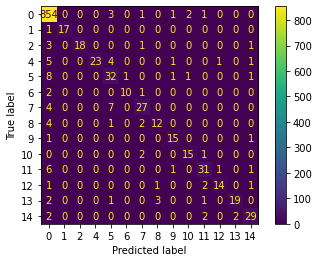

In [86]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf, Xval, Yval) 

In [89]:
Ypred = clf.predict(Xval)

In [103]:
np.array(Yval)

array([0, 0, 0, ..., 0, 0, 0])

In [108]:
for row, (yy, ypred) in enumerate(zip(np.array(Yval), Ypred)):
    if yy != ypred:
        import pdb; pdb.set_trace()

> /tmp/ipykernel_971920/2458908960.py(1)<module>()
----> 1 for row, (yy, ypred) in enumerate(zip(np.array(Yval), Ypred)):
      2     if yy != ypred:
      3         import pdb; pdb.set_trace()

8
0
8
18
file_name        All_KYC_Docs_90b
text                            K
c_x                      0.062268
c_y                      0.390496
n_image_width                 569
                       ...       
99                      -0.102376
100                      -0.02355
order                    0.538462
is_key                          1
key_label                       8
Name: 735, Length: 109, dtype: object
*** AttributeError: 'Series' object has no attribute 'text'
*** KeyError: 'text'


BdbQuit: 

In [77]:
import matplotlib.pyplot as plt
import numpy as np

def plot_normal_line(A, B, C, ax=None, **kwargs):
    """ Plot equation of Ax+By+C=0"""
    if ax is None:
        ax = plt.gca()
    if A == 0 and B == 0:
        raise Exception('A or B should be non-zero')
    if B == 0:
        # plot vertical
        ax.vlines(-C / A, *ax.get_ylim(), **kwargs)
    else:
        # plot functoon
        x = np.array(ax.get_xlim())
        y = (A*x+C) / -B
        ax.plot(x, y, **kwargs)
plot_normal_line(*clf.coef_[0], clf.intercept_)

TypeError: plot_normal_line() takes from 3 to 4 positional arguments but 103 were given

In [74]:
print('w = ',clf.coef_)
print('b = ',clf.intercept_)
# print('Indices of support vectors = ', clf.support_)
# print('Support vectors = ', clf.support_vectors_)
# print('Number of support vectors for each class = ', clf.n_support_)
# print('Coefficients of the support vector in the decision function = ', np.abs(clf.dual_coef_))


w =  [[ 9.24019048e+00 -1.75581191e+00 -6.44856652e-01 ...  3.44443828e-01
  -5.09000792e-01 -2.39047853e-01]
 [-1.88265091e+00 -1.20370350e+00 -4.86813733e-01 ... -1.57355233e-01
  -7.26466617e-02 -5.53802527e-03]
 [-1.20957390e+00 -7.29063624e-01  2.55933812e-01 ...  1.14461023e-01
   3.60204585e-01  7.48115462e-02]
 ...
 [-2.56021794e+00  6.35438299e-01 -3.18280930e-01 ...  5.78369712e-01
   1.75381104e-01  6.53313314e-01]
 [-1.90907732e+00  9.13767791e-01  3.17593002e-01 ... -1.81118442e-01
   3.98818016e-01  8.15948265e-01]
 [-3.05298801e+00  1.59452528e+00  2.56357899e-01 ... -2.96298882e-01
  -2.61961737e-01 -2.14304431e-01]]
b =  [-0.40573489 -1.52368285 -1.73703881 -1.76269469 -1.1236835  -1.58923511
 -2.33962596 -2.12036828 -2.14496097 -2.09855586 -1.54243164 -2.14516637
 -2.29143713 -2.11367186]


In [64]:


Y_pred = lm.predict(Xval)


In [66]:
Y_pred.shape

(1207,)

In [13]:
X_train, Y_train = train_df.drop(['file_name', 'text', 'n_image_width', 'n_image_height', 'is_key', 'order', 'key_label'], axis=1).to_numpy(), train_df['key_label'].to_numpy()
print(f"X_train = {X_train.shape}\nY_train = {Y_train.shape}")

X_train = (3730, 102)
Y_train = (3730,)


In [14]:
X_test, Y_test = test_df.drop(['file_name', 'text', 'n_image_width', 'n_image_height', 'is_key', 'order', 'key_label'], axis=1).to_numpy(), test_df['key_label'].to_numpy()
print(f"X_train = {X_test.shape}\nY_train = {Y_test.shape}")

X_train = (2033, 102)
Y_train = (2033,)


In [15]:
def print_report(y_test, y_pred):
    print(f"Confusion Matrix\n\n{metrics.confusion_matrix(y_test, y_pred)}")
    print(f"\n\n\n\nClassification Report\n\n{metrics.classification_report(y_test, y_pred)}")

def get_res(y_test, y_pred, n=10):
    res = pd.DataFrame({'Pred': Y_pred, 'True': Y_test})
    return res[res['True']!=0].sample(n=10)

def visualize_attribution(attr_test, heading='', legend_needed=True):
    r = lambda: random.randint(0,255)
    x_axis_data = np.arange(attr_test.shape[1])
    x_axis_data_labels = ['C-X', 'C-Y'] + [f'Embedding-{str(i+1)}' for i in np.arange(attr_test.shape[1]-2)]
    width = 1/attr_test.shape[0]
    FONT_SIZE = 18
    legends = []
    plt.figure(figsize=(25, 10))
    ax = plt.subplot()
    ax.set_title(heading)
    ax.set_ylabel('Attributions')
    plt.rc('font', size=FONT_SIZE)
    plt.rc('axes', titlesize=FONT_SIZE)
    plt.rc('axes', labelsize=FONT_SIZE)
    plt.rc('legend', fontsize=FONT_SIZE - 4)
    for i in range(attr_test.shape[0]):
        bar_color = '#%02X%02X%02X' % (r(),r(),r())
        ax.bar(x_axis_data + i * width, attr_test[i], width, align='center', alpha=0.8, color=bar_color)
        legends.append(f'{bar_color} - {i}')
    ax.autoscale_view()
    plt.tight_layout()
    plt.xticks(rotation=90)
    ax.set_xticks(x_axis_data + 0.5)
    ax.set_xticklabels(x_axis_data_labels)
    if legend_needed:
        plt.legend(legends, loc=0)
    plt.show()

Confusion Matrix

[[1414    0    0    0    4    0   10    7    3    0    6    2    7    4]
 [   1   28    0    0    2    0    0    0    0    0    0    0    0    0]
 [   1    0   27    0    0    0    1    0    0    0    0    0    0    0]
 [   3    0    0   46    1    0    0    0    0    0    0    0    0    0]
 [  13    0    0    1   65    0   11    0    0    0    0    0    0    0]
 [   5    0    0    0    1   24    1    0    0    0    0    0    0    0]
 [   3    0    0    0    1    0   61    0    0    0    0    0    0    0]
 [   5    0    0    0    0    0    9   34    0    0    0    0    2    0]
 [   2    0    0    0    0    0    0    1   26    0    0    0    0    0]
 [   4    0    0    0    1    0    0    0    0   25    1    0    0    0]
 [   3    0    0    0    1    0    0    0    0    0   50    0    1    0]
 [   2    0    0    0    0    0    0    0    0    0    0   27    0    0]
 [   1    0    0    0    0    0    0    1    0    0    0    0   28    0]
 [   7    0    0    0    1    0  

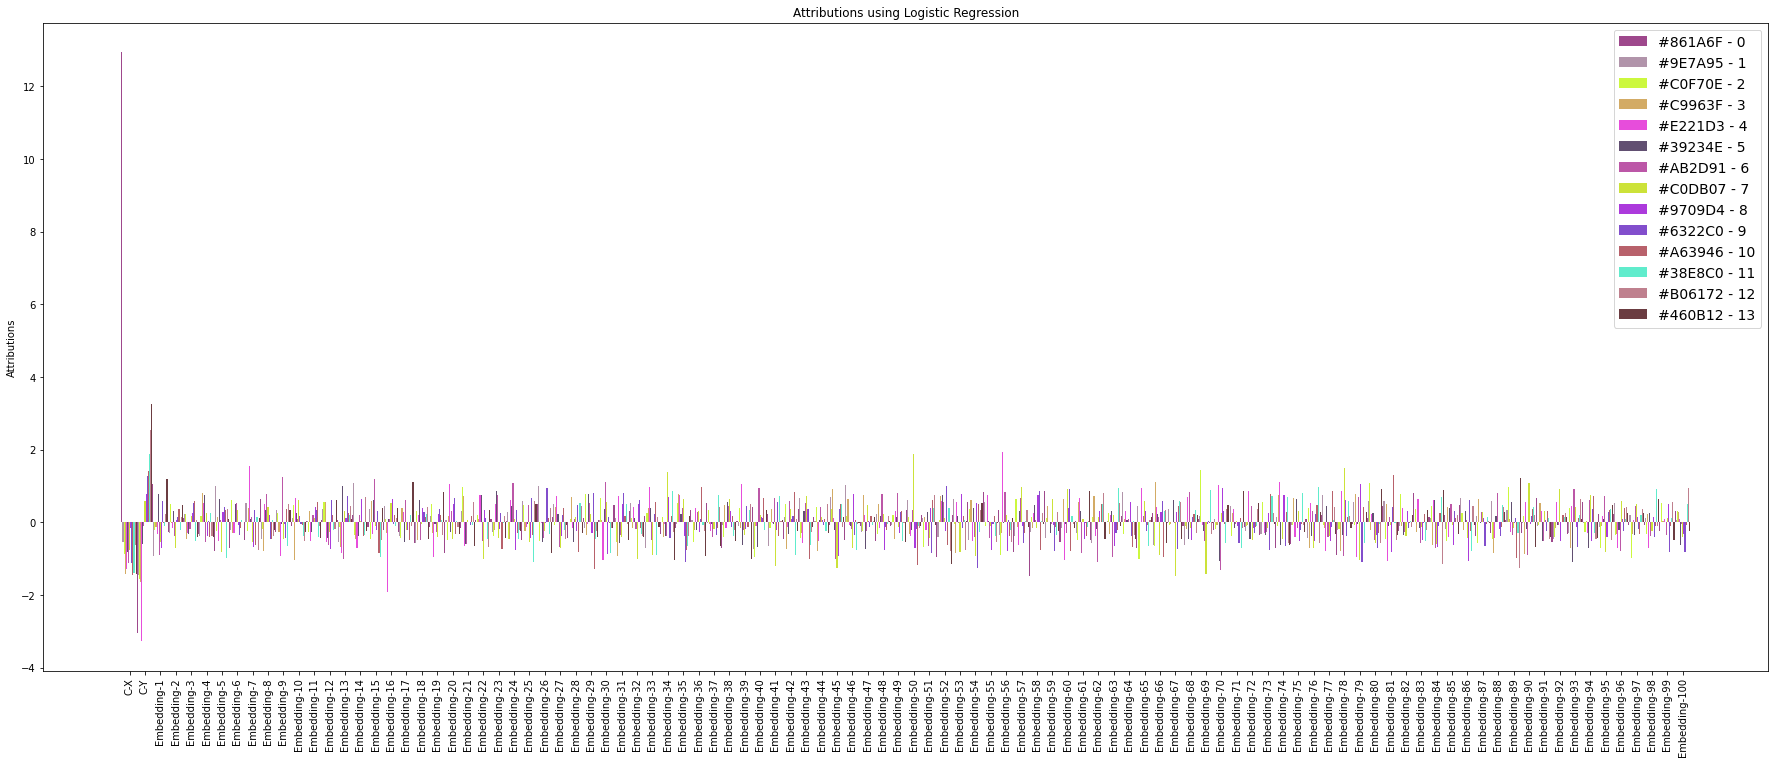

,Pred,True
1038,11,11
1814,4,4
1922,4,4
762,4,4
956,4,4
1479,7,7
1935,14,14
226,14,14
675,5,5
799,14,14


In [16]:
clf = LogisticRegression()
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
print_report(Y_test, Y_pred)
visualize_attribution(clf.coef_, f'Attributions using Logistic Regression')
res = get_res(Y_test, Y_pred)
res

In [17]:
clf = svm.SVC()
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
print_report(Y_test, Y_pred)
res = get_res(Y_test, Y_pred)
res

Confusion Matrix

[[1429    0    0    0    0    0   20    4    3    0    0    1    0    0]
 [   5   26    0    0    0    0    0    0    0    0    0    0    0    0]
 [   3    0   26    0    0    0    0    0    0    0    0    0    0    0]
 [   5    0    0   44    1    0    0    0    0    0    0    0    0    0]
 [  16    0    0    1   56    0   17    0    0    0    0    0    0    0]
 [   6    0    0    0    0   24    1    0    0    0    0    0    0    0]
 [   6    0    0    0    0    0   59    0    0    0    0    0    0    0]
 [   6    0    0    0    0    0    9   35    0    0    0    0    0    0]
 [   3    0    0    0    0    0    0    0   26    0    0    0    0    0]
 [   8    0    0    0    0    0    0    0    0   23    0    0    0    0]
 [   5    0    0    0    0    0    0    0    0    0   50    0    0    0]
 [   4    0    0    0    0    0    0    0    0    0    0   25    0    0]
 [   1    0    0    0    0    0    0    1    0    0    0    0   28    0]
 [  11    0    0    0    0    0  

,Pred,True
300,1,1
1893,12,12
1433,0,11
262,7,7
916,9,9
1599,14,14
1920,5,5
952,5,5
1083,7,7
450,5,5


Confusion Matrix

[[1397    1    1    1    1    2   17    6    6    1    2    6   15    1]
 [   3   28    0    0    0    0    0    0    0    0    0    0    0    0]
 [   1    0   27    0    0    0    1    0    0    0    0    0    0    0]
 [   5    0    0   44    1    0    0    0    0    0    0    0    0    0]
 [  11    0    1    1   60    0   17    0    0    0    0    0    0    0]
 [   3    0    0    2    0   25    1    0    0    0    0    0    0    0]
 [   3    0    0    0    0    0   62    0    0    0    0    0    0    0]
 [   4    0    0    0    0    1    9   35    0    0    0    0    1    0]
 [   3    0    0    0    0    0    0    0   26    0    0    0    0    0]
 [   5    0    0    0    0    0    0    0    0   26    0    0    0    0]
 [   3    0    0    1    0    0    0    0    0    0   50    0    1    0]
 [   1    0    0    0    0    0    0    0    0    0    0   27    0    1]
 [   1    0    0    0    0    0    0    1    0    0    0    0   28    0]
 [   9    0    0    0    1    0  

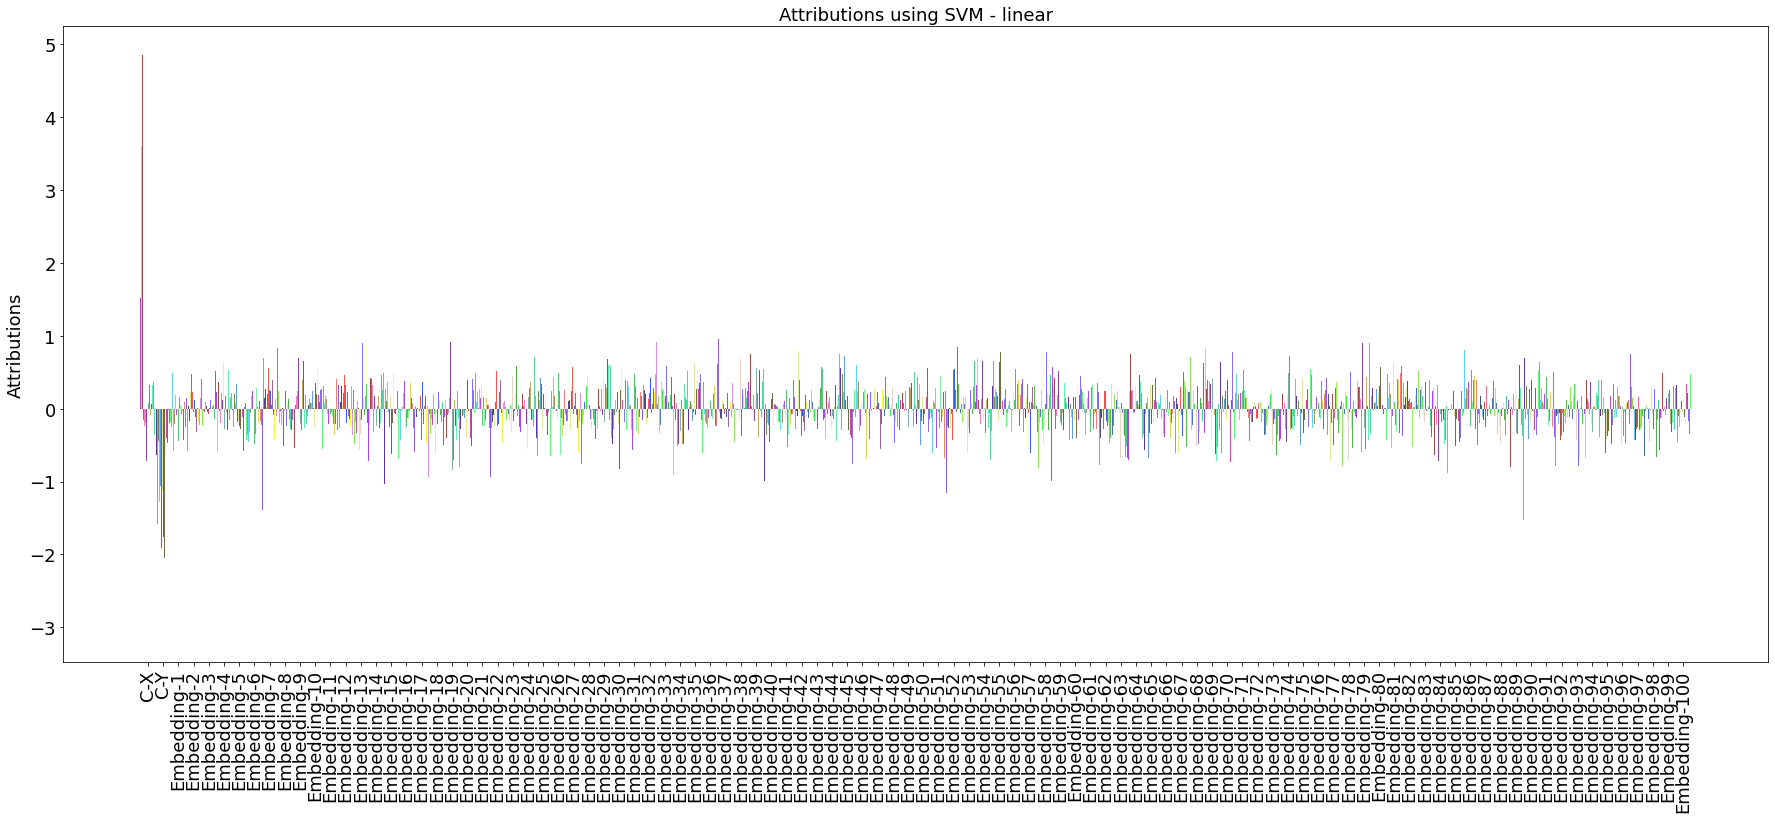

,Pred,True
107,0,8
116,14,12
787,11,11
608,4,4
1027,7,7
1417,0,6
887,5,5
389,4,4
781,9,9
1238,0,9


In [18]:
clf = svm.SVC(kernel='linear')
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
print_report(Y_test, Y_pred)
visualize_attribution(clf.coef_, f'Attributions using SVM - linear', legend_needed=False)
res = get_res(Y_test, Y_pred)
res

Confusion Matrix

[[1405    1    3    4    6    1    7    6    5    1    9    2    2    5]
 [   1   27    0    0    0    0    0    0    0    0    0    0    3    0]
 [   0    0   27    0    1    1    0    0    0    0    0    0    0    0]
 [   2    0    0   45    2    0    0    1    0    0    0    0    0    0]
 [  13    1    0    2   64    0    6    3    0    0    1    0    0    0]
 [   0    0    0    2    0   25    3    0    0    1    0    0    0    0]
 [   3    0    1    0    2    0   56    3    0    0    0    0    0    0]
 [   1    0    1    1    2    0    4   38    0    1    1    0    0    1]
 [   2    0    0    0    0    1    0    0   25    0    0    0    1    0]
 [   0    1    0    0    0    0    3    1    0   25    0    1    0    0]
 [   1    0    0    0    0    0    0    1    1    0   49    1    1    1]
 [   0    0    0    0    0    0    2    0    0    0    1   26    0    0]
 [   0    0    0    0    0    0    1    0    0    0    0    0   29    0]
 [   5    0    0    0    0    0  

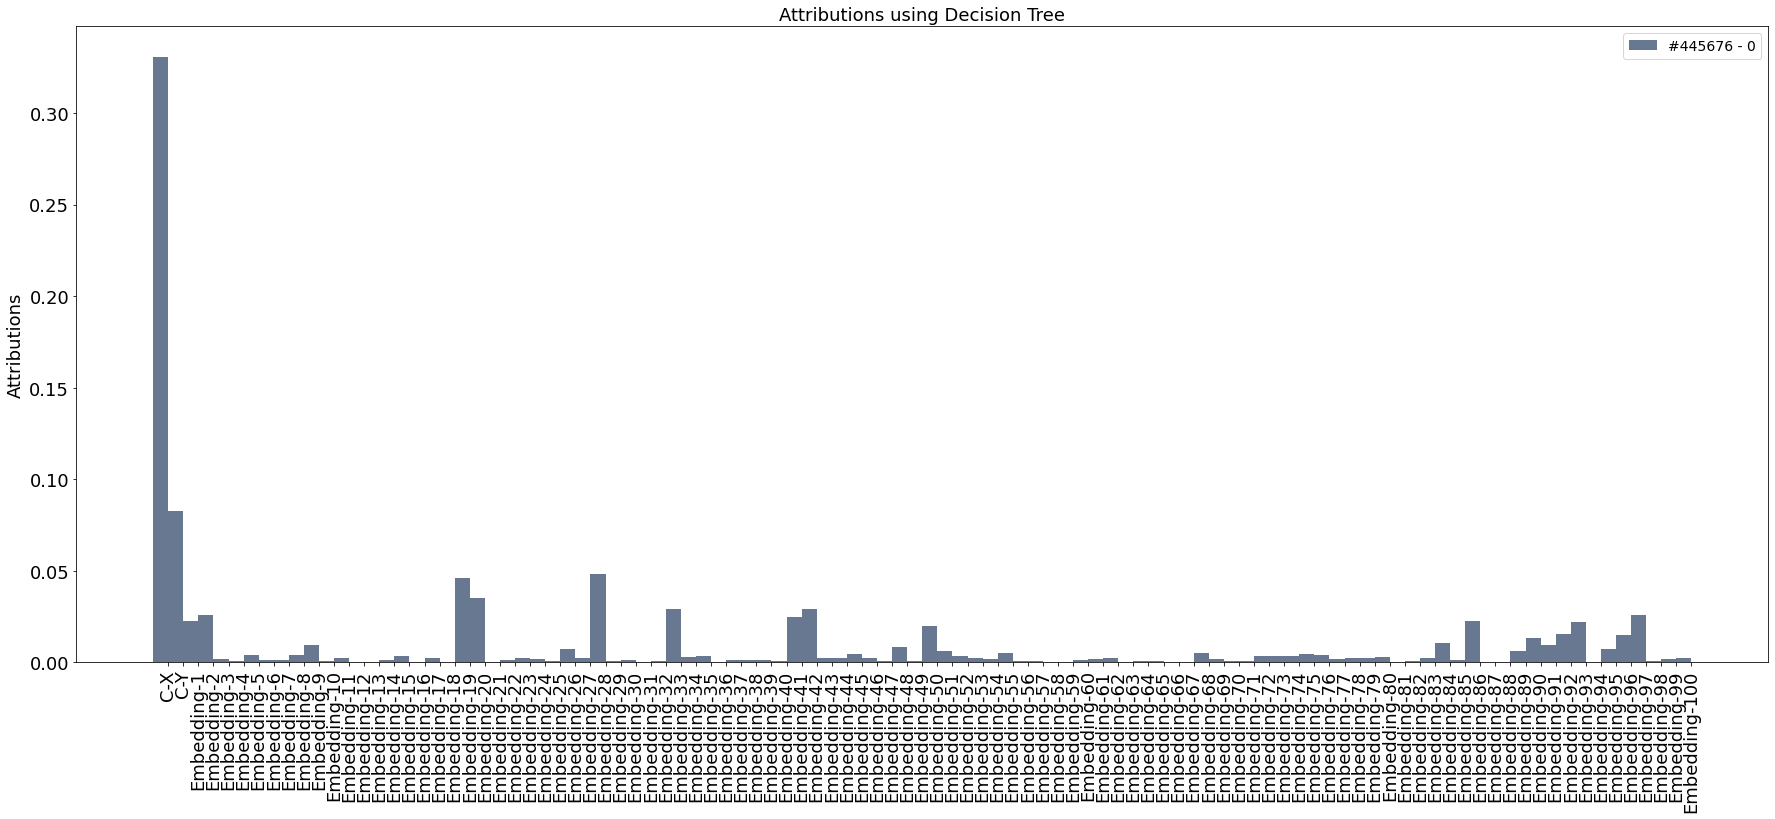

,Pred,True
1182,13,13
1192,1,1
1886,10,10
1367,9,9
644,11,11
1087,8,8
810,1,1
512,13,1
1010,5,5
1626,4,4


In [19]:
clf = DecisionTreeClassifier()
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
print_report(Y_test, Y_pred)
visualize_attribution(np.expand_dims(clf.feature_importances_, axis=0), f'Attributions using Decision Tree')
res = get_res(Y_test, Y_pred)
res

Confusion Matrix

[[1441    0    0    1    1    1    4    5    3    0    0    1    0    0]
 [   3   28    0    0    0    0    0    0    0    0    0    0    0    0]
 [   2    0   27    0    0    0    0    0    0    0    0    0    0    0]
 [   5    0    0   44    1    0    0    0    0    0    0    0    0    0]
 [  16    0    0    1   68    0    4    1    0    0    0    0    0    0]
 [   4    0    0    0    0   26    1    0    0    0    0    0    0    0]
 [   3    0    0    0    2    0   59    1    0    0    0    0    0    0]
 [   6    0    0    0    1    0    6   37    0    0    0    0    0    0]
 [   3    0    0    0    0    0    0    0   26    0    0    0    0    0]
 [   8    0    0    0    0    0    0    0    0   23    0    0    0    0]
 [   4    0    0    0    1    0    0    0    0    0   50    0    0    0]
 [   3    0    0    0    0    0    0    0    0    0    0   26    0    0]
 [   1    0    0    0    0    0    0    0    0    0    0    0   29    0]
 [   6    0    0    0    0    0  

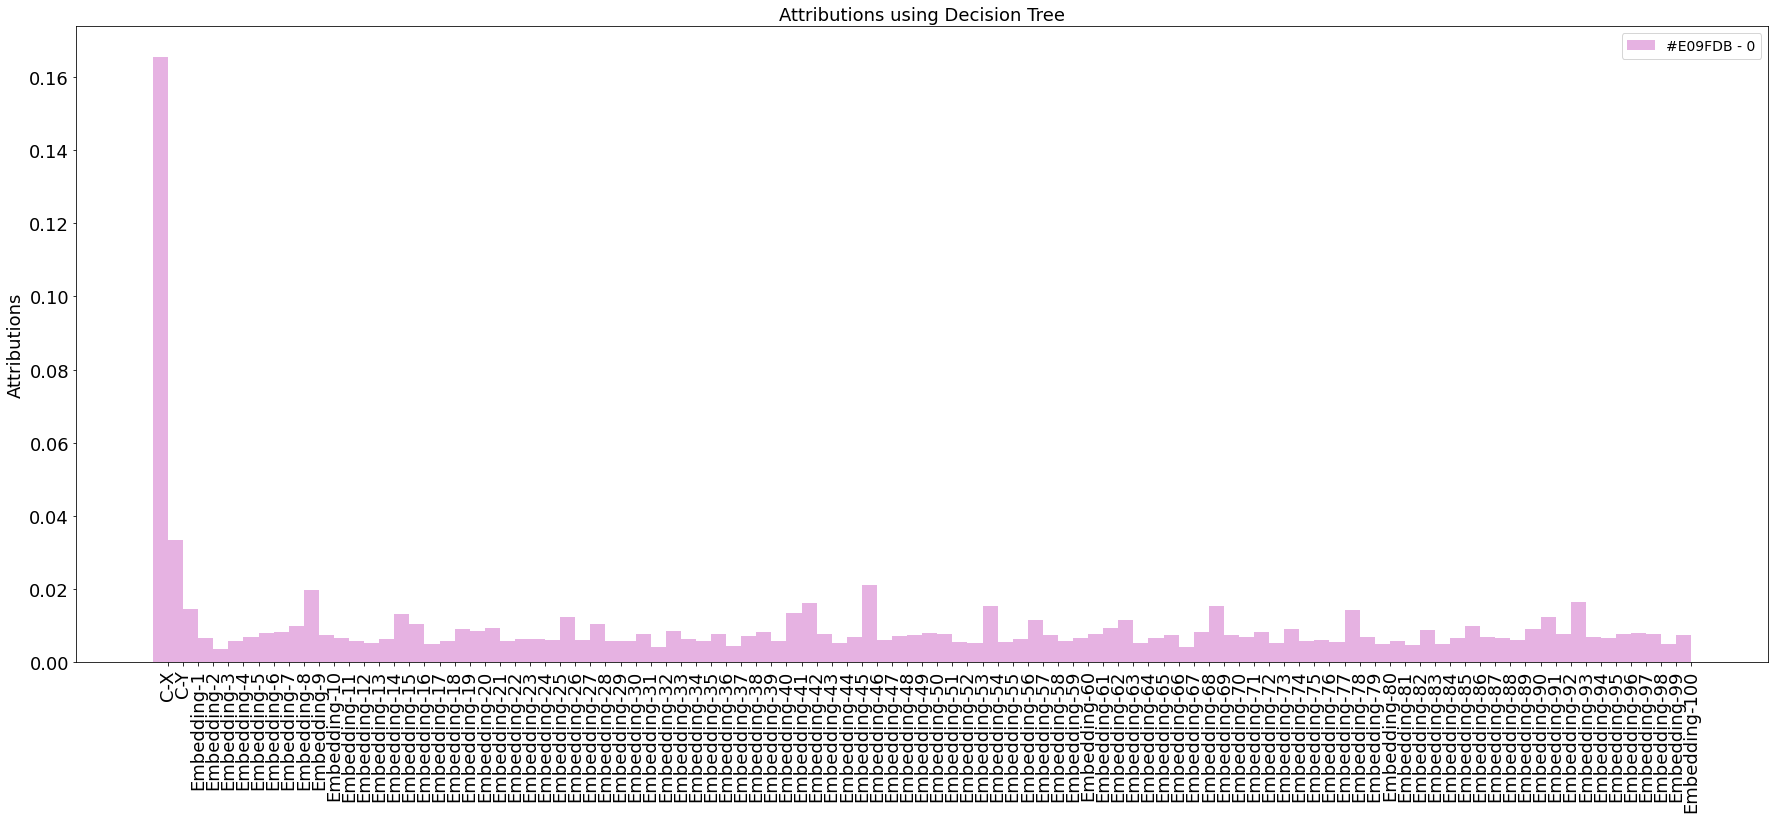

,Pred,True
1094,11,11
690,6,6
709,7,8
1498,13,13
607,4,4
20,4,4
1818,8,7
1986,4,4
755,5,5
1921,4,4


In [20]:
clf = RandomForestClassifier()
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
print_report(Y_test, Y_pred)
visualize_attribution(np.expand_dims(clf.feature_importances_, axis=0), f'Attributions using Decision Tree')
res = get_res(Y_test, Y_pred)
res

In [21]:
clf = KNeighborsClassifier()
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
print_report(Y_test, Y_pred)
res = get_res(Y_test, Y_pred)
res

Confusion Matrix

[[1397    0    1    0    9    0   11   11    9    0    1    5    8    5]
 [   5   26    0    0    0    0    0    0    0    0    0    0    0    0]
 [   2    0   26    0    0    1    0    0    0    0    0    0    0    0]
 [   3    0    0   44    1    0    0    0    1    0    0    0    0    1]
 [  14    0    0    1   69    0    6    0    0    0    0    0    0    0]
 [   4    0    0    0    0   25    1    0    0    0    0    1    0    0]
 [   4    0    0    0    2    0   59    0    0    0    0    0    0    0]
 [   3    0    0    0    0    0    9   35    1    0    0    0    1    1]
 [   2    0    0    0    0    0    0    0   27    0    0    0    0    0]
 [   6    0    0    0    0    0    0    0    0   24    0    1    0    0]
 [   5    0    0    0    0    0    0    0    0    0   50    0    0    0]
 [   2    0    0    0    0    0    0    0    0    0    0   26    1    0]
 [   2    0    0    0    0    0    0    0    0    0    0    0   28    0]
 [  10    0    0    0    0    0  

,Pred,True
999,1,1
1491,11,11
1738,7,7
1541,1,1
493,12,12
52,13,13
283,0,14
1931,11,11
1490,11,11
1465,4,4


In [22]:
clf = BaggingClassifier(n_estimators=10, base_estimator=RandomForestClassifier())
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
print_report(Y_test, Y_pred)
res = get_res(Y_test, Y_pred)
res

Confusion Matrix

[[1446    0    0    0    0    0    3    4    3    0    0    1    0    0]
 [   3   28    0    0    0    0    0    0    0    0    0    0    0    0]
 [   2    0   27    0    0    0    0    0    0    0    0    0    0    0]
 [   6    0    0   44    0    0    0    0    0    0    0    0    0    0]
 [  15    0    0    1   69    0    4    1    0    0    0    0    0    0]
 [   4    0    0    0    0   26    1    0    0    0    0    0    0    0]
 [   4    0    0    0    2    0   58    1    0    0    0    0    0    0]
 [   7    0    0    0    0    0    9   34    0    0    0    0    0    0]
 [   3    0    0    0    0    0    0    0   26    0    0    0    0    0]
 [   8    0    0    0    0    0    0    0    0   23    0    0    0    0]
 [   5    0    0    0    0    0    0    0    0    0   50    0    0    0]
 [   4    0    0    0    0    0    0    0    0    0    0   25    0    0]
 [   1    0    0    0    0    0    0    0    0    0    0    0   29    0]
 [   9    0    0    0    0    0  

,Pred,True
416,10,10
1373,11,11
988,14,14
1141,0,10
755,5,5
1145,13,13
1694,7,7
1738,7,7
893,4,4
819,5,5


Confusion Matrix

[[1442    0    0    1    1    1    4    4    3    0    0    1    0    0]
 [   3   28    0    0    0    0    0    0    0    0    0    0    0    0]
 [   2    0   27    0    0    0    0    0    0    0    0    0    0    0]
 [   6    0    0   44    0    0    0    0    0    0    0    0    0    0]
 [  14    0    0    1   69    0    5    1    0    0    0    0    0    0]
 [   2    0    0    1    1   26    1    0    0    0    0    0    0    0]
 [   3    0    0    0    1    0   58    3    0    0    0    0    0    0]
 [   6    0    0    0    0    0    8   36    0    0    0    0    0    0]
 [   3    0    0    0    0    0    0    0   26    0    0    0    0    0]
 [   6    0    0    0    1    0    0    0    0   24    0    0    0    0]
 [   4    0    0    0    0    0    0    0    0    0   50    0    0    1]
 [   4    0    0    0    0    0    0    0    0    0    0   25    0    0]
 [   1    0    0    0    0    0    0    1    0    0    0    0   28    0]
 [  10    0    0    0    0    0  

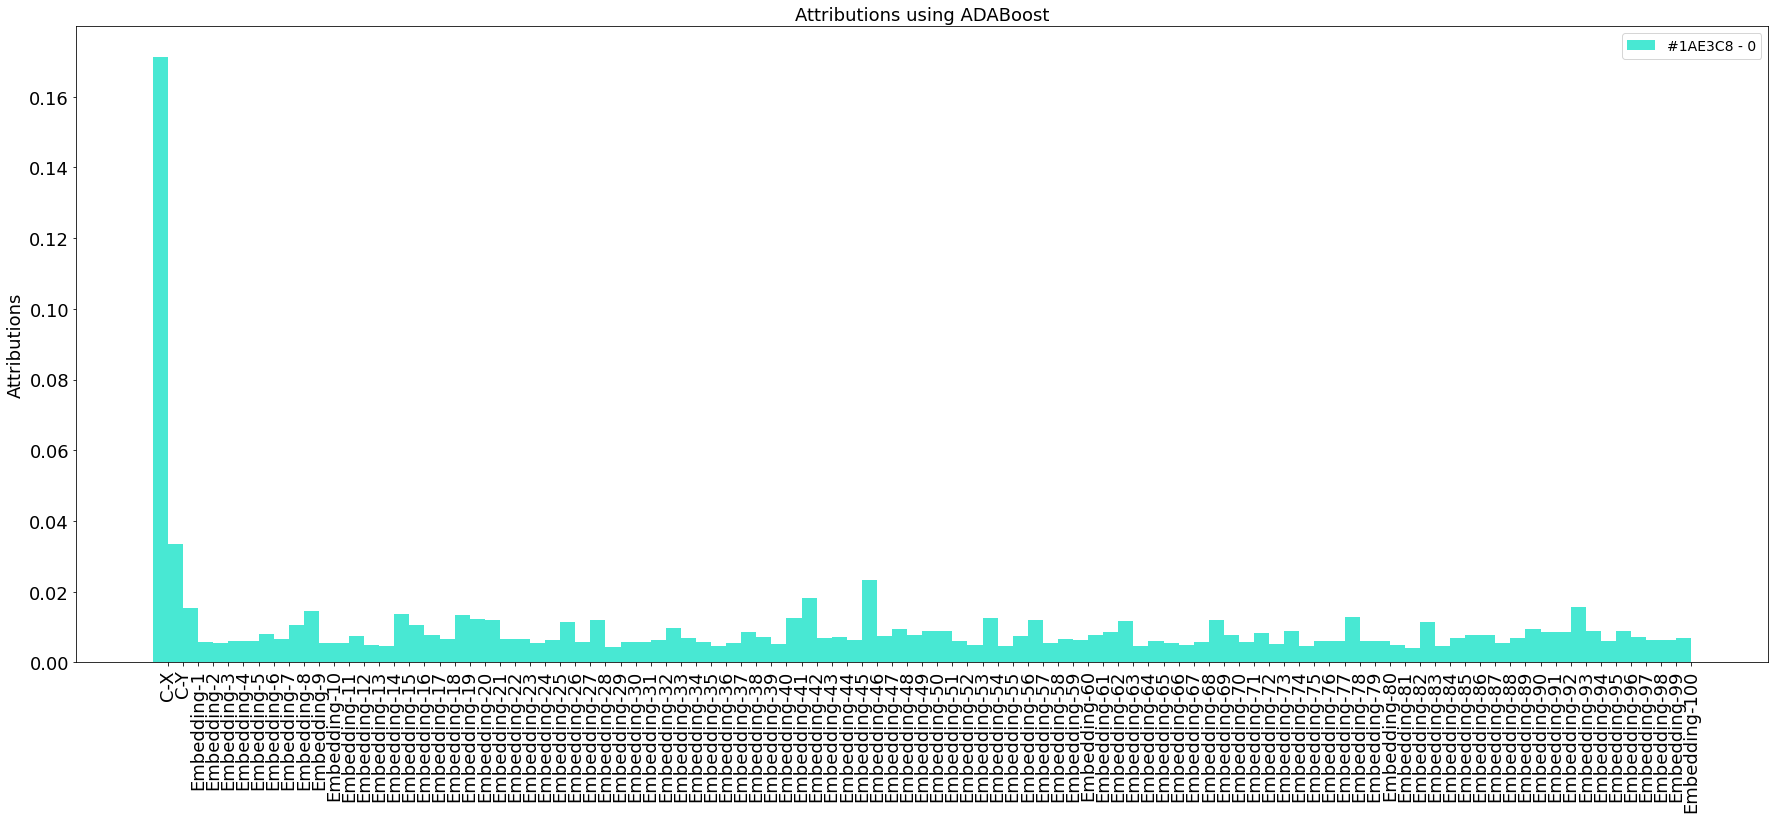

,Pred,True
451,5,5
398,6,6
404,7,7
1920,5,5
201,7,7
1105,14,14
1620,5,5
1041,12,12
27,6,6
1002,2,2


In [23]:
clf = AdaBoostClassifier(n_estimators=50, learning_rate=1, base_estimator=RandomForestClassifier())
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
print_report(Y_test, Y_pred)
visualize_attribution(np.expand_dims(clf.feature_importances_, axis=0), f'Attributions using ADABoost')
res = get_res(Y_test, Y_pred)
res